In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors
import requests
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import glob
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# download weights from 'https://nlp.stanford.edu/data/glove.6B.zip'
# after getting the weights 'glove.6B.300d.txt' in the directory, run following command:
# python -m gensim.scripts.glove2word2vec --input  glove.6B.300d.txt --output glove.6B.300d.w2vformat.txt

# Load the pre-trained GloVe embeddings
glove_model = KeyedVectors.load_word2vec_format('glove.6B.300d.w2vformat.txt', binary=False)



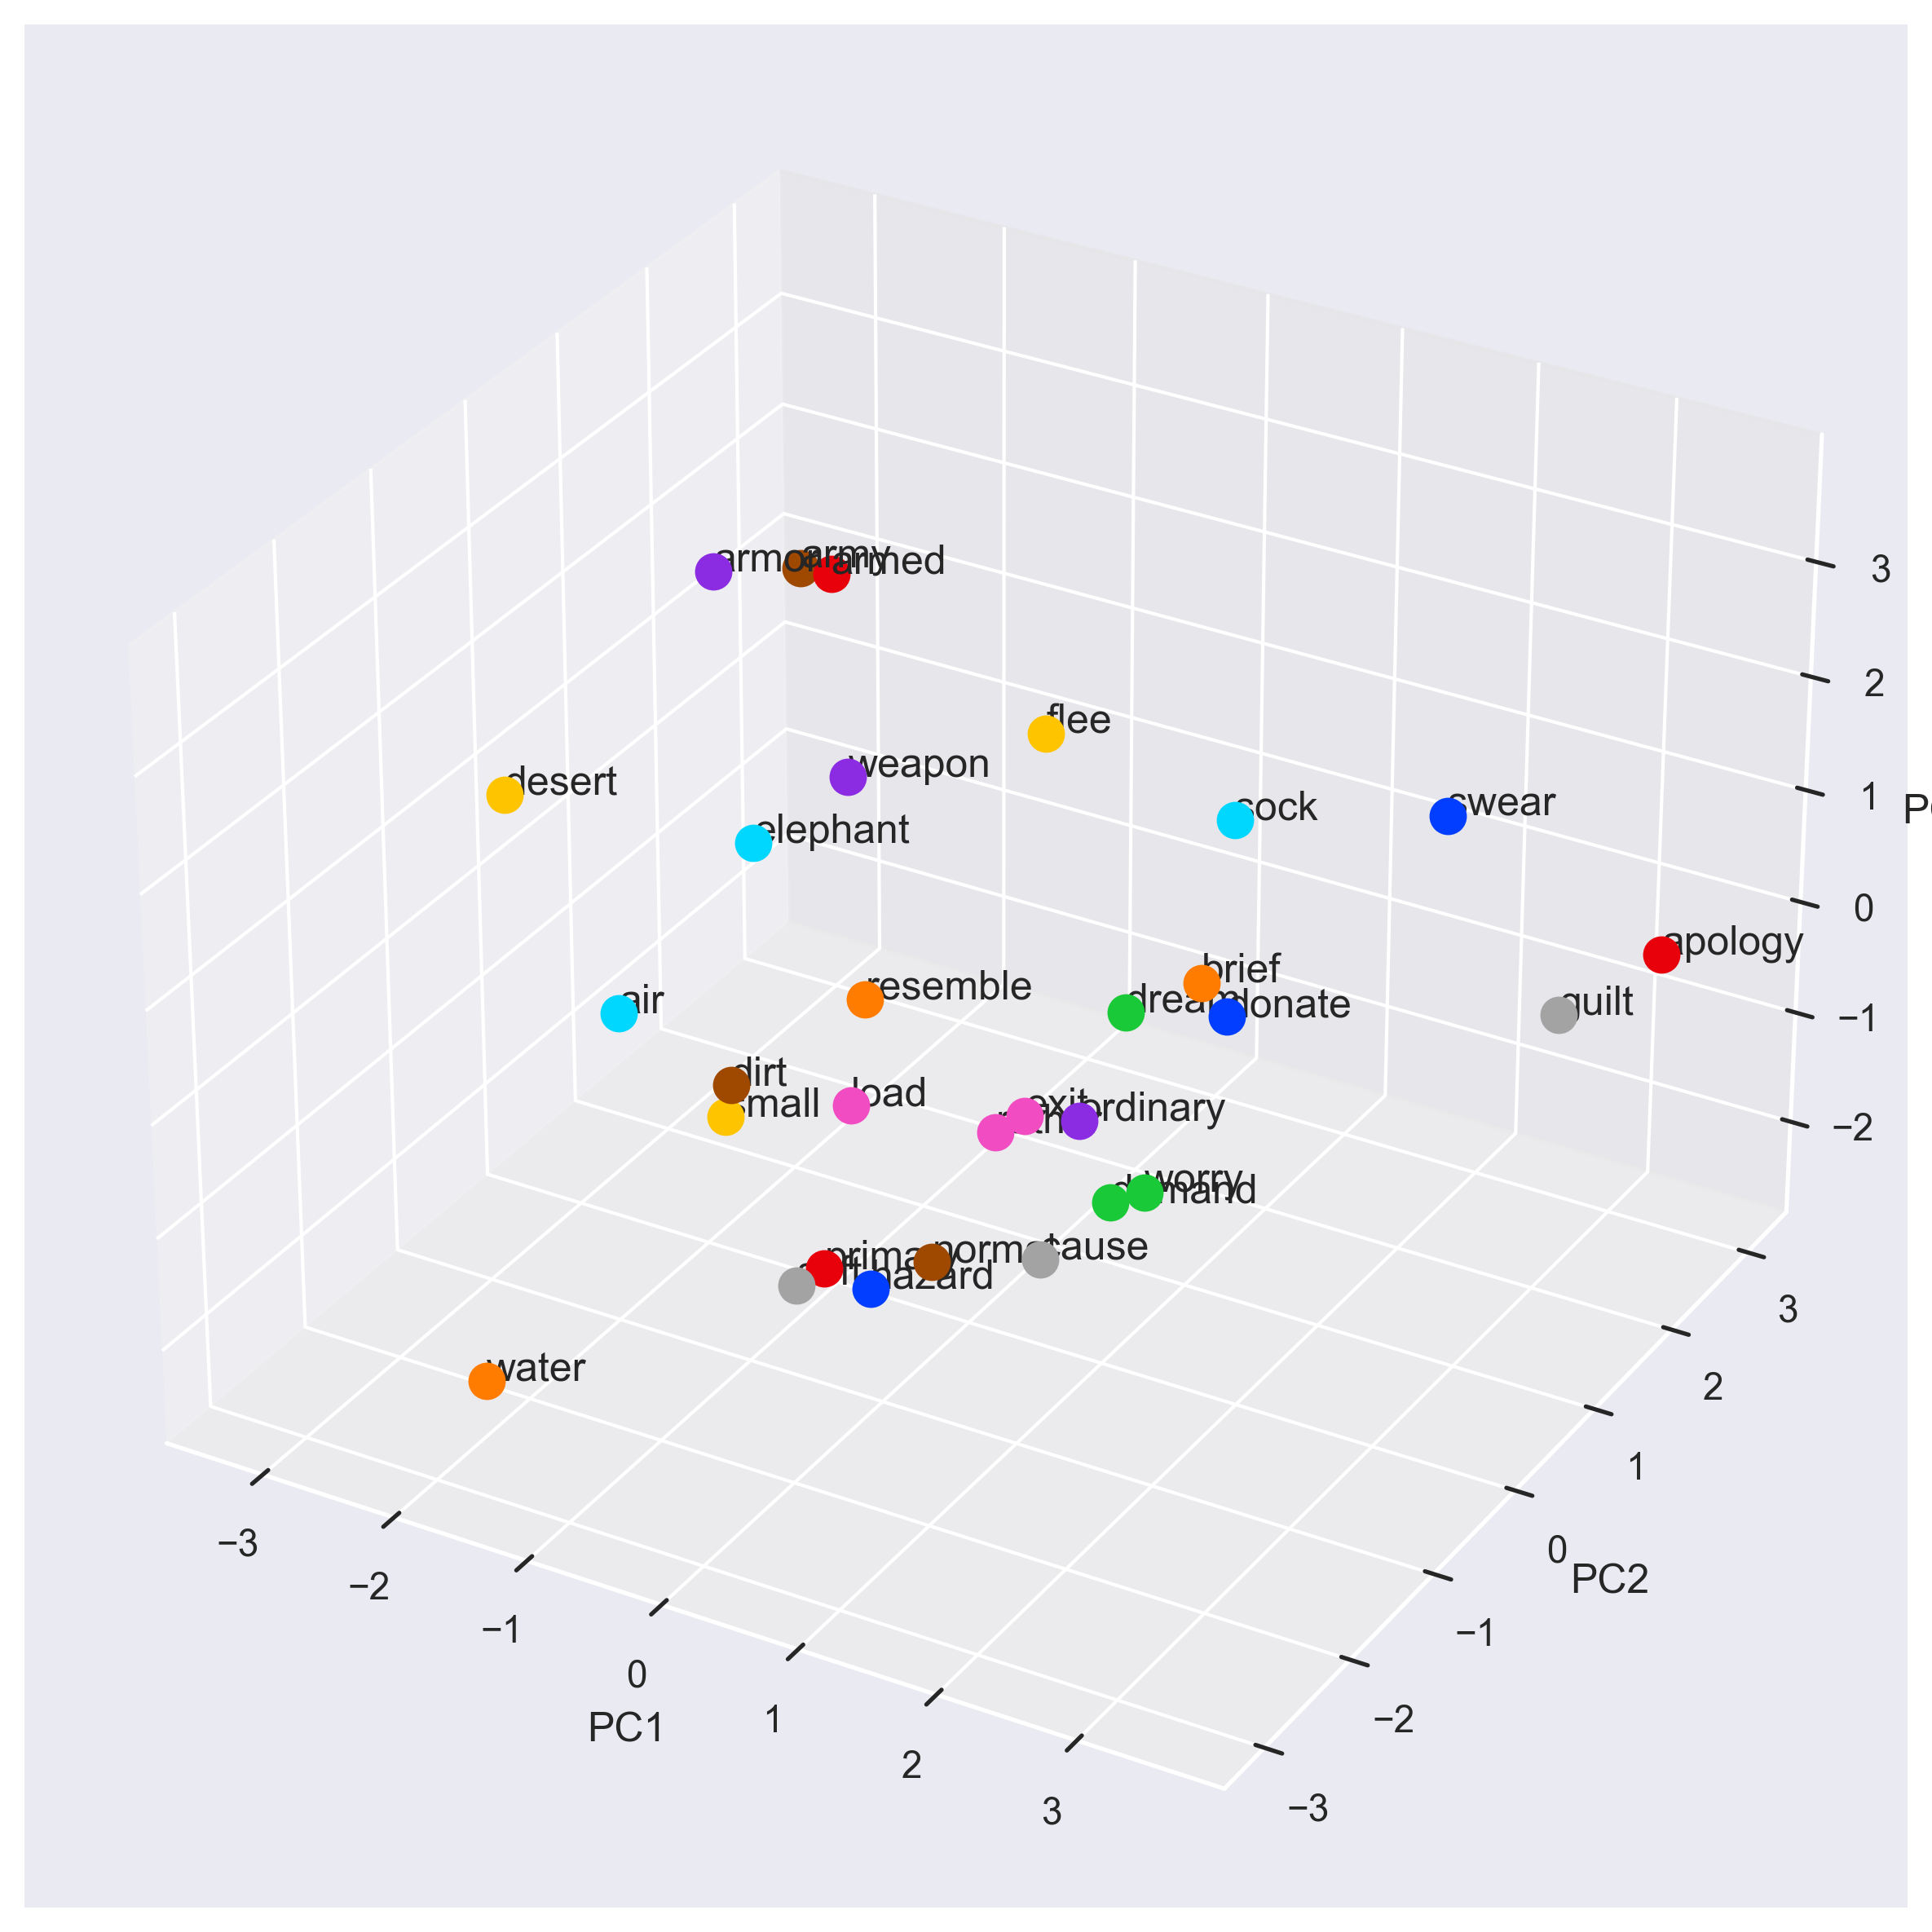

In [87]:
# Find all words from file "plaintexter_*.txt"
words = []
fine_grained_words=[]
for file in glob.glob("plaintexter_*.txt"):
    subwords=[]
    with open(file) as f:
        for line in f:
            for word in line.split():
                words.append(word)


# Get the embeddings for each word
word_vectors = np.array([glove_model[w] for w in words])

# Use PCA to reduce the dimensionality of the embeddings to 2D
pca = PCA(n_components=3)
word_vectors_pca = pca.fit_transform(word_vectors)

# Create a dataframe with the word vectors and their labels
df = pd.DataFrame({'x': word_vectors_pca[:, 0], 'y': word_vectors_pca[:, 1], 'z': word_vectors_pca[:, 2], 'word': words})

# Define the size and colors of the scatter points
sizes = [100, 200, 300, 400, 500]
colors = sns.color_palette('bright', n_colors=len(words))


# Create the 3D scatter plot
sns.set(style='darkgrid')
fig = plt.figure(figsize=(10, 10),dpi=300)
ax = fig.add_subplot(111, projection='3d')
for i in range(len(words)):
    ax.scatter(df['x'][i], df['y'][i], df['z'][i], s=sizes[0], color=colors[i])
    ax.text(df['x'][i], df['y'][i], df['z'][i], df['word'][i], fontsize=12)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

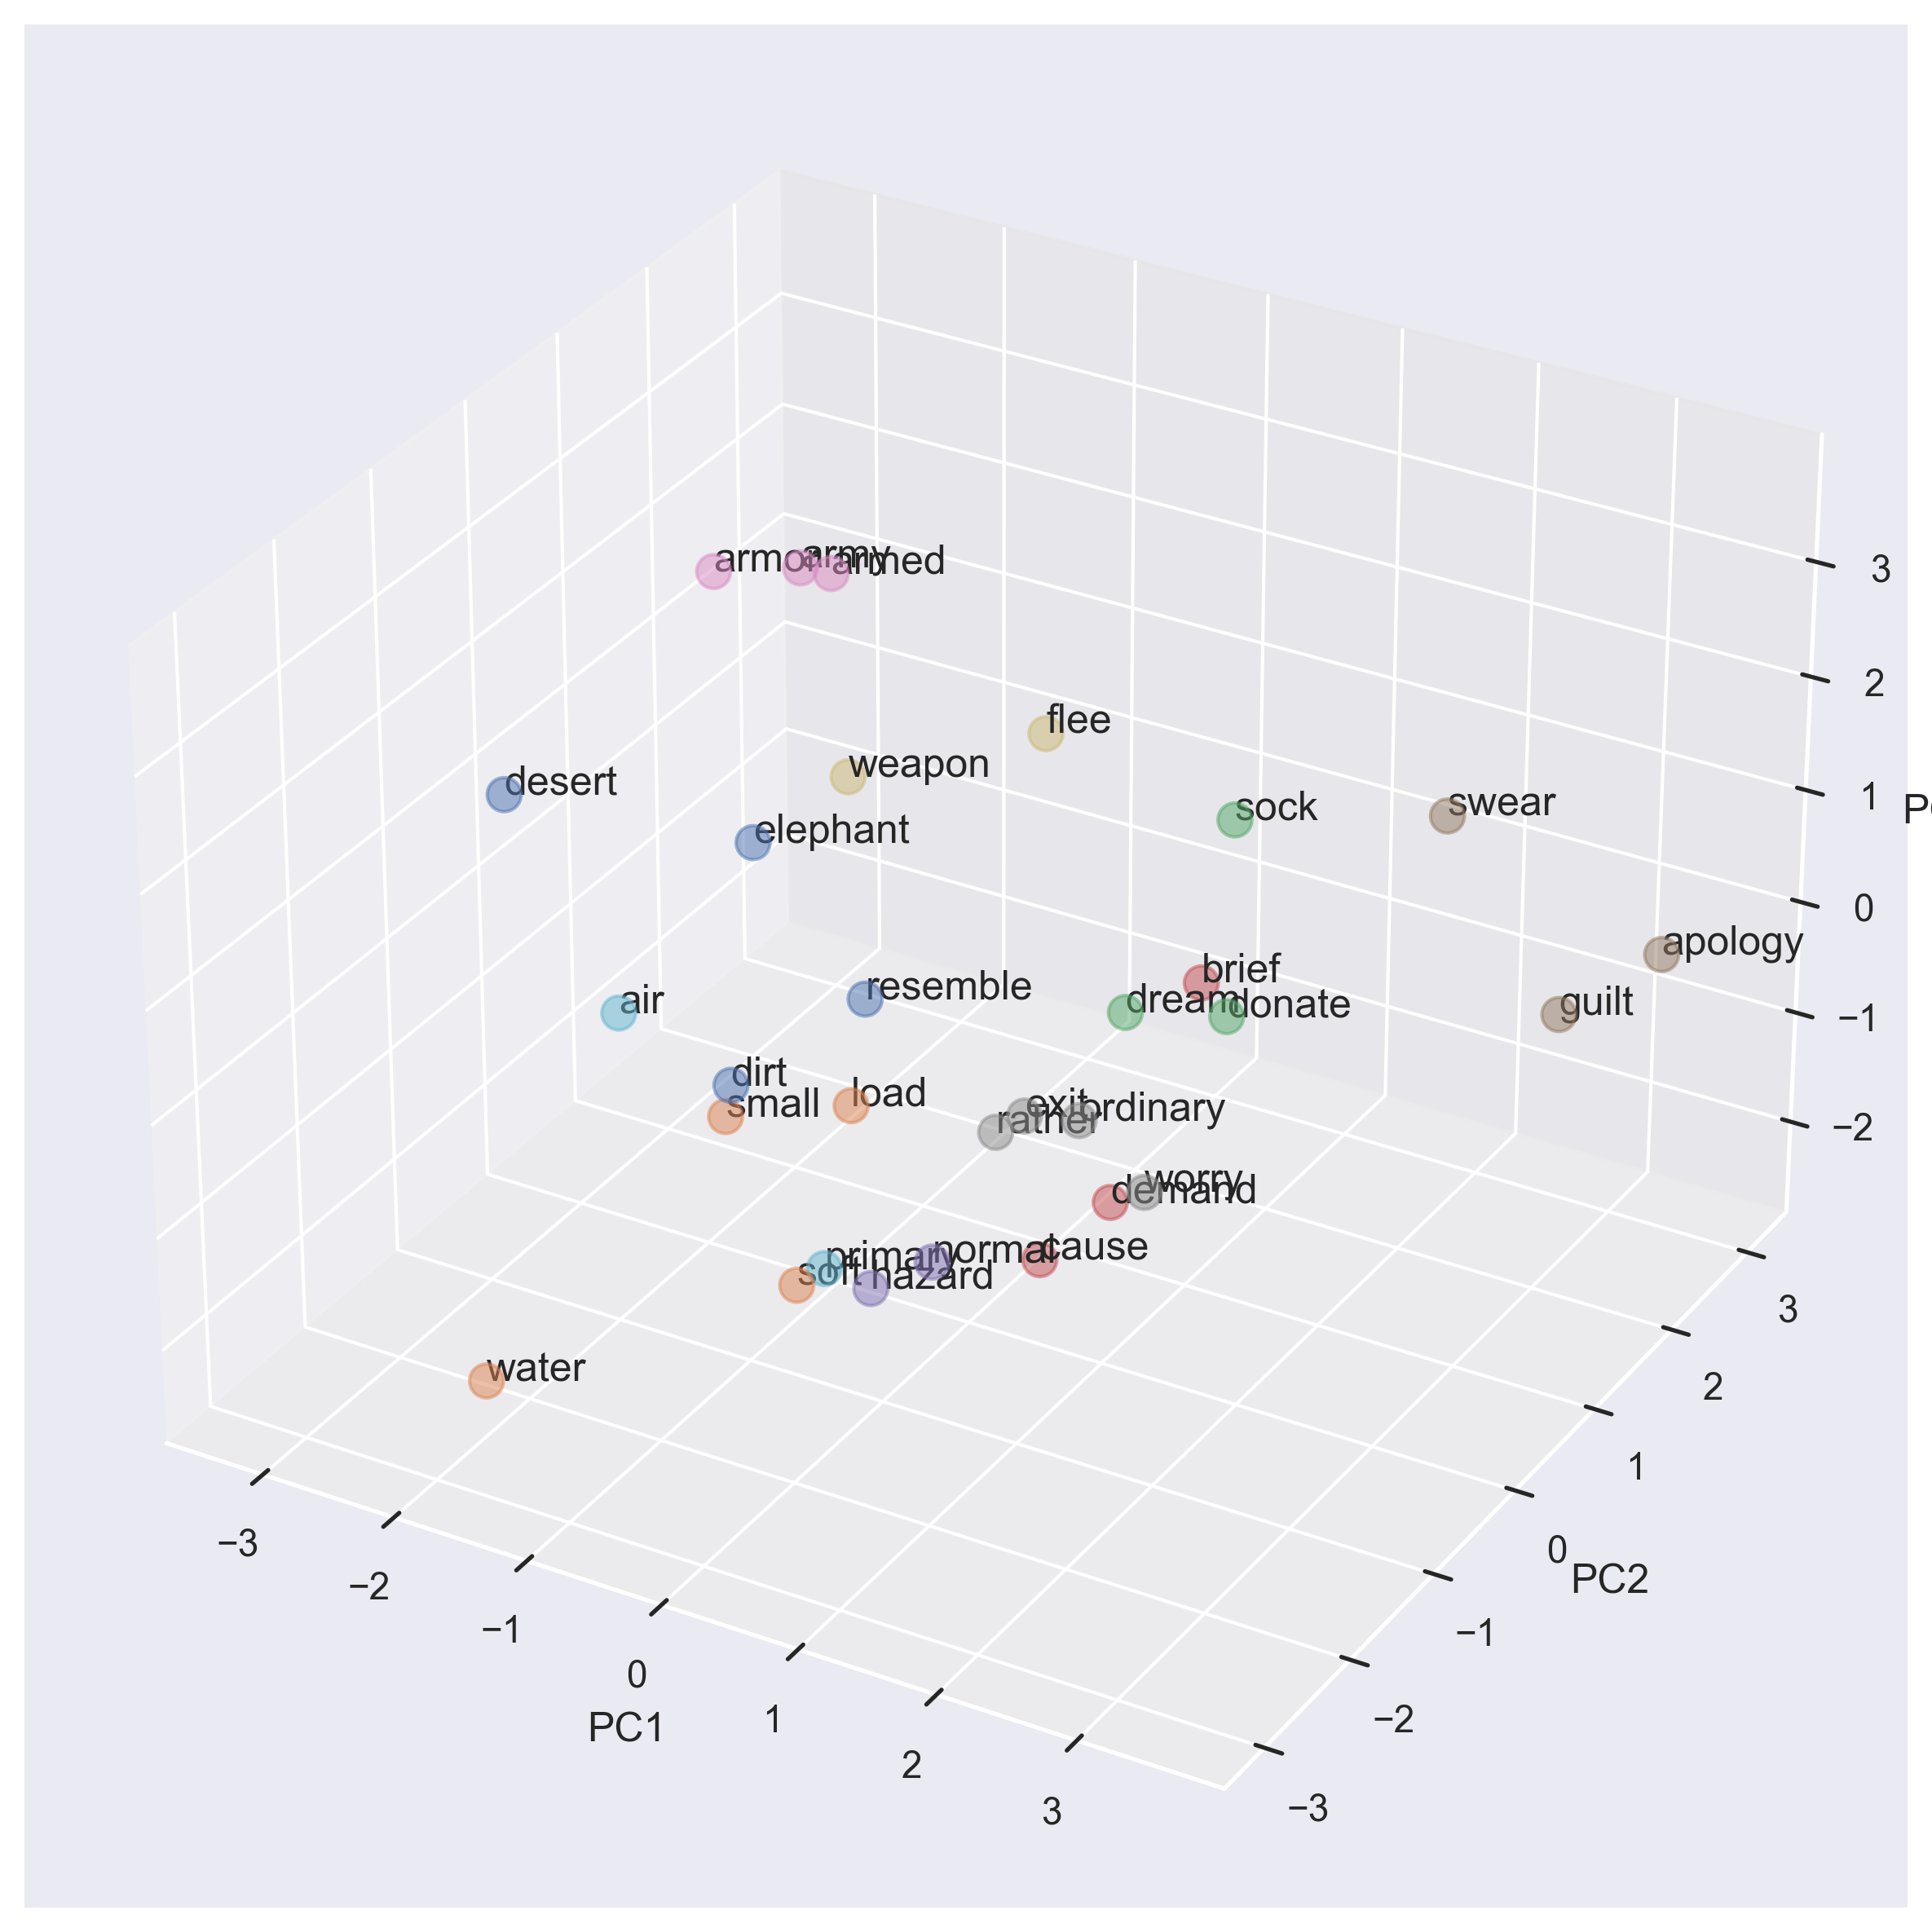

In [92]:
# # Perform K-means clustering on the word vectors
# kmeans = KMeans(n_clusters=10, random_state=0)
# clusters = kmeans.fit_predict(word_vectors_pca)
# Perform spectral clustering with 5 clusters
spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', n_neighbors=3)
clusters = spectral.fit_predict(word_vectors_pca)

# Create a dataframe with the word vectors, their labels, and their cluster assignments
df = pd.DataFrame({'x': word_vectors_pca[:, 0], 'y': word_vectors_pca[:, 1], 'z': word_vectors_pca[:, 2], 'word': words, 'cluster': clusters})


# Create the 3D scatter plot, colored by cluster assignment
sns.set(style='darkgrid')
fig = plt.figure(figsize=(10, 10),dpi=300)
ax = fig.add_subplot(111, projection='3d')
for cluster in df['cluster'].unique():
    cluster_df = df[df['cluster'] == cluster]
    ax.scatter(cluster_df['x'], cluster_df['y'], cluster_df['z'], color=sns.color_palette()[cluster%10], s=100, alpha=0.5)
    for i in range(len(cluster_df)):
        ax.text(cluster_df['x'].iloc[i], cluster_df['y'].iloc[i], cluster_df['z'].iloc[i], cluster_df['word'].iloc[i], fontsize=12)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

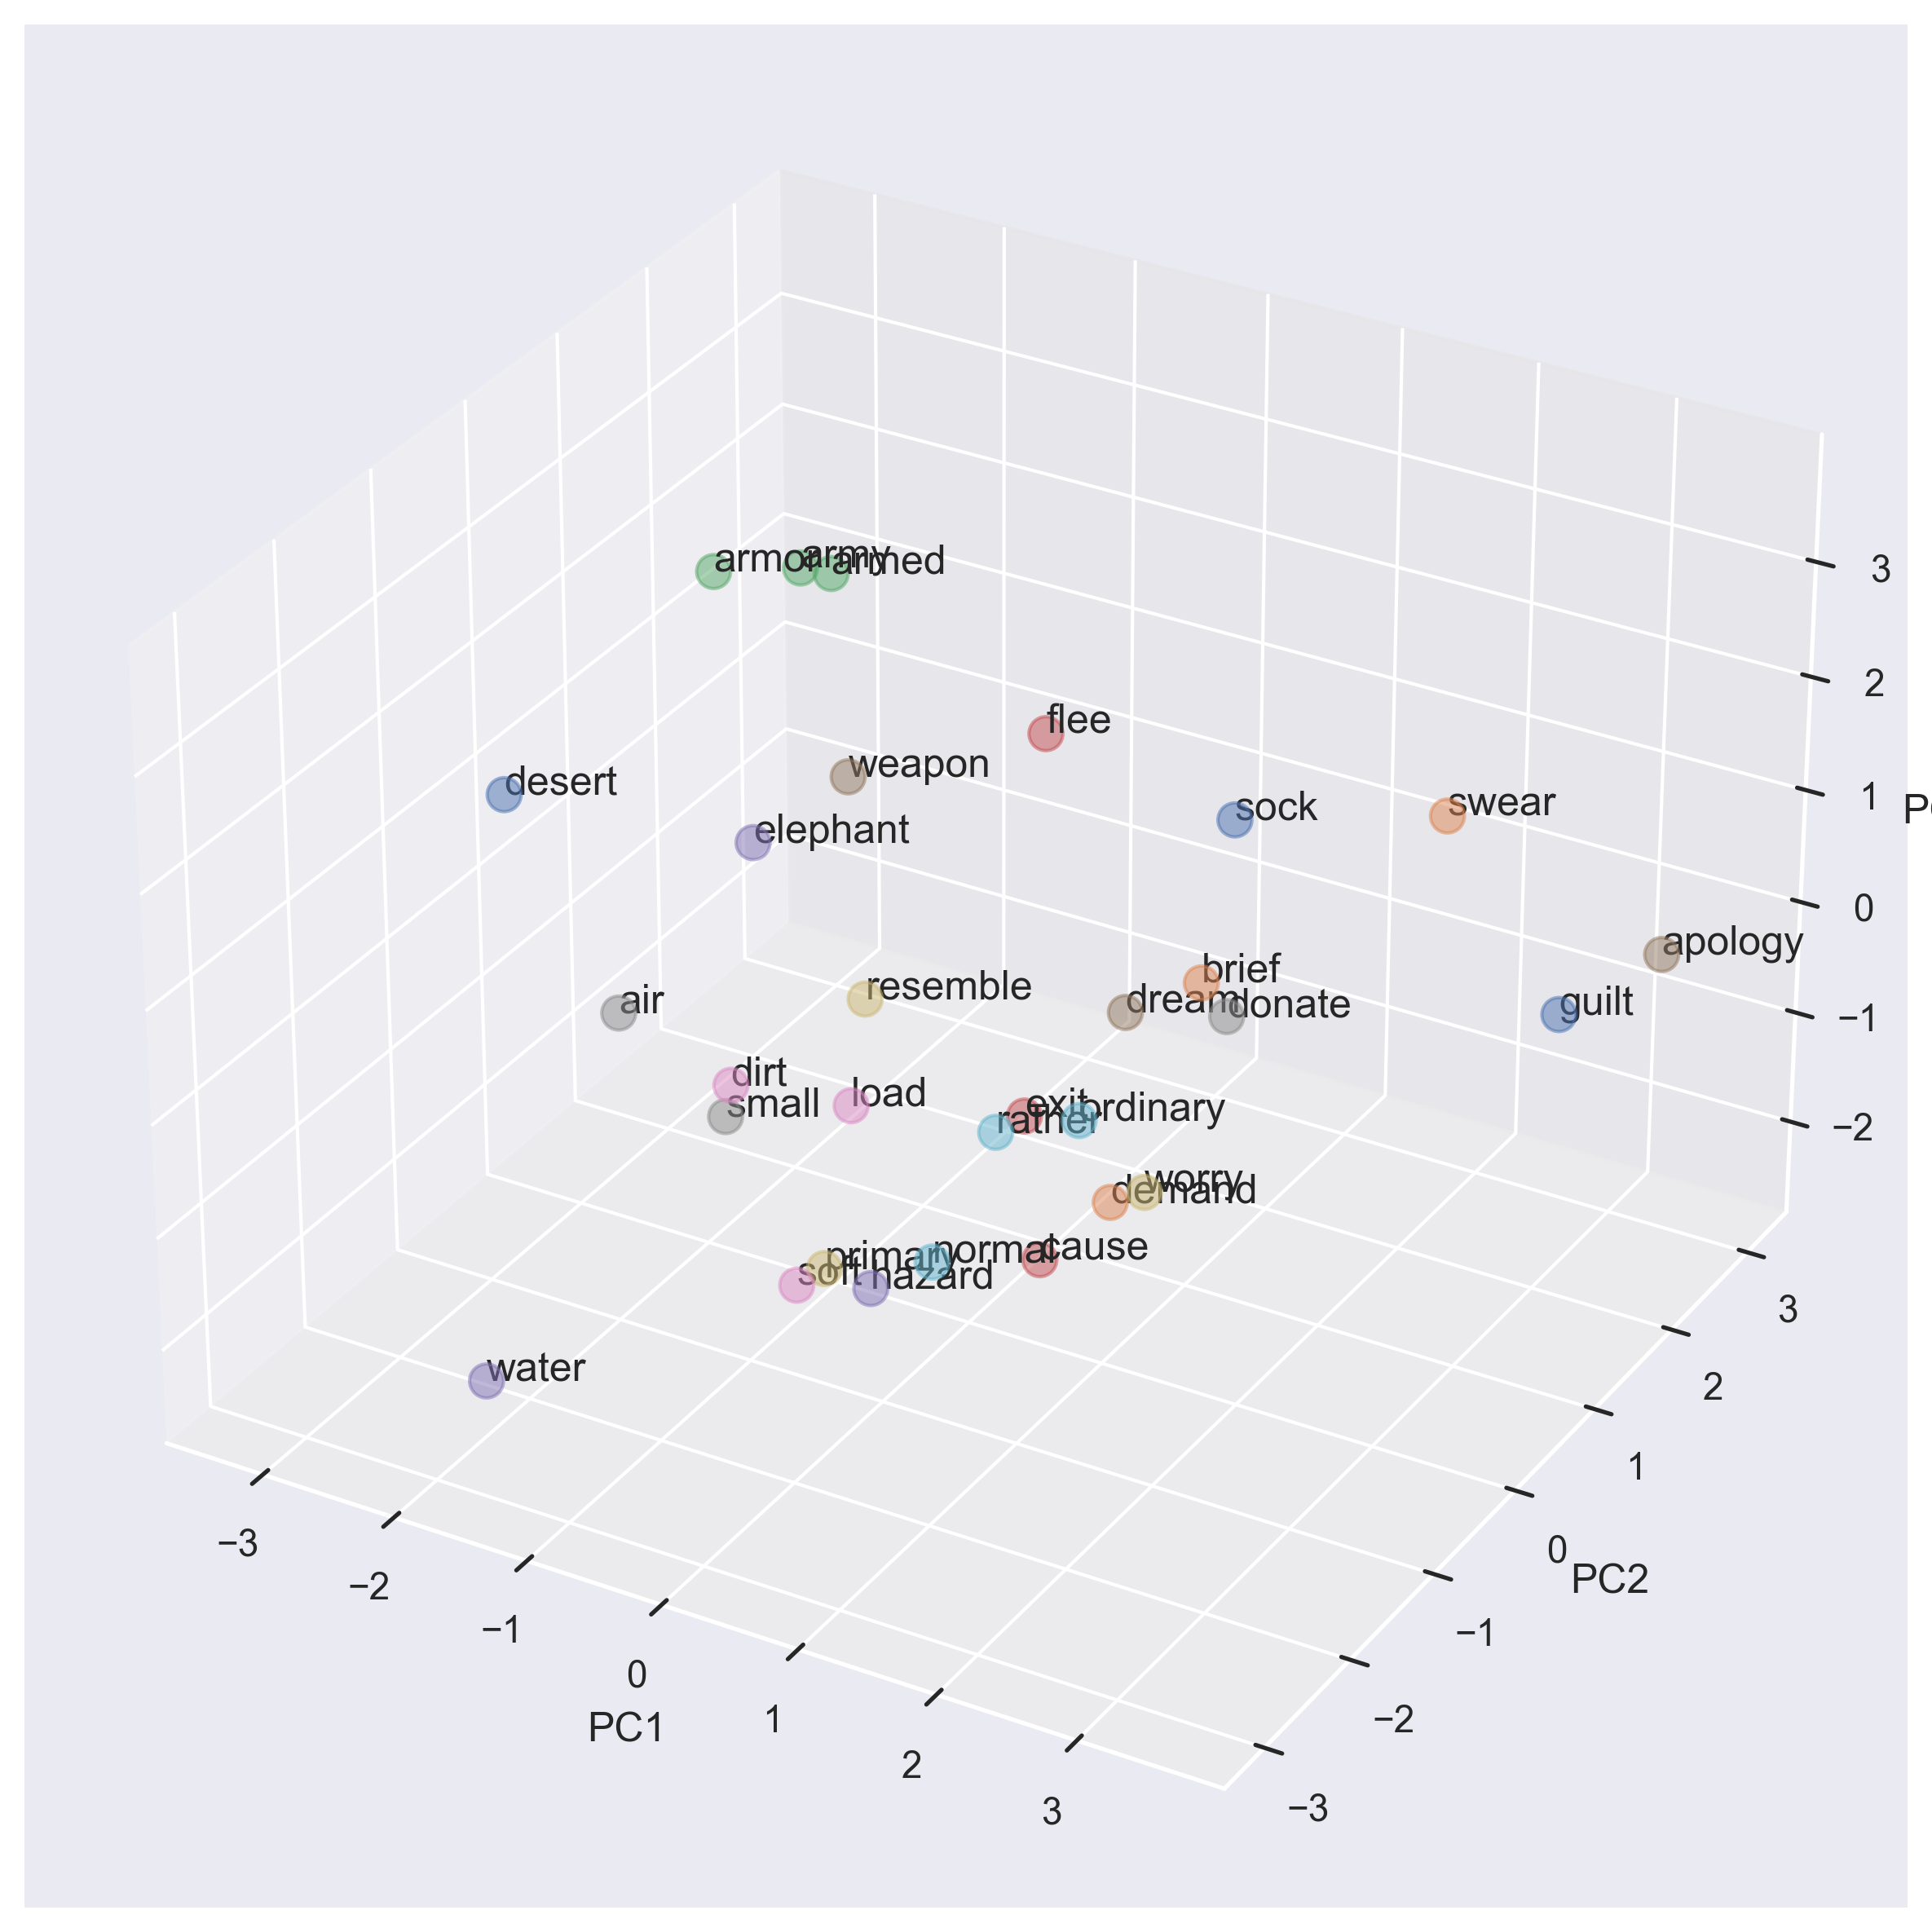

In [89]:

candidates=[]
j=0
for i in range(len(words)):
    if i%3==0:
        j+=1
    candidates.append(j)

candidates=np.array(candidates)

# Create a dataframe with the word vectors, their labels, and their cluster assignments
df = pd.DataFrame({'x': word_vectors_pca[:, 0], 'y': word_vectors_pca[:, 1], 'z': word_vectors_pca[:, 2], 'word': words, 'candidates': candidates})



# Create the 3D scatter plot, colored by cluster assignment
sns.set(style='darkgrid')
fig = plt.figure(figsize=(10, 10),dpi=300)
ax = fig.add_subplot(111, projection='3d')
for cand in df['candidates'].unique():
    cluster_df = df[df['candidates'] == cand]
    ax.scatter(cluster_df['x'], cluster_df['y'], cluster_df['z'], color=sns.color_palette()[cand%10], s=100, alpha=0.5)
    for i in range(len(cluster_df)):
        ax.text(cluster_df['x'].iloc[i], cluster_df['y'].iloc[i], cluster_df['z'].iloc[i], cluster_df['word'].iloc[i], fontsize=12)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

C:\Users\dianu\AppData\Local\Temp\ipykernel_2704\1637045051.py:49: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[i, 0], X[i, 1], X[i, 2], s=100,c=color)


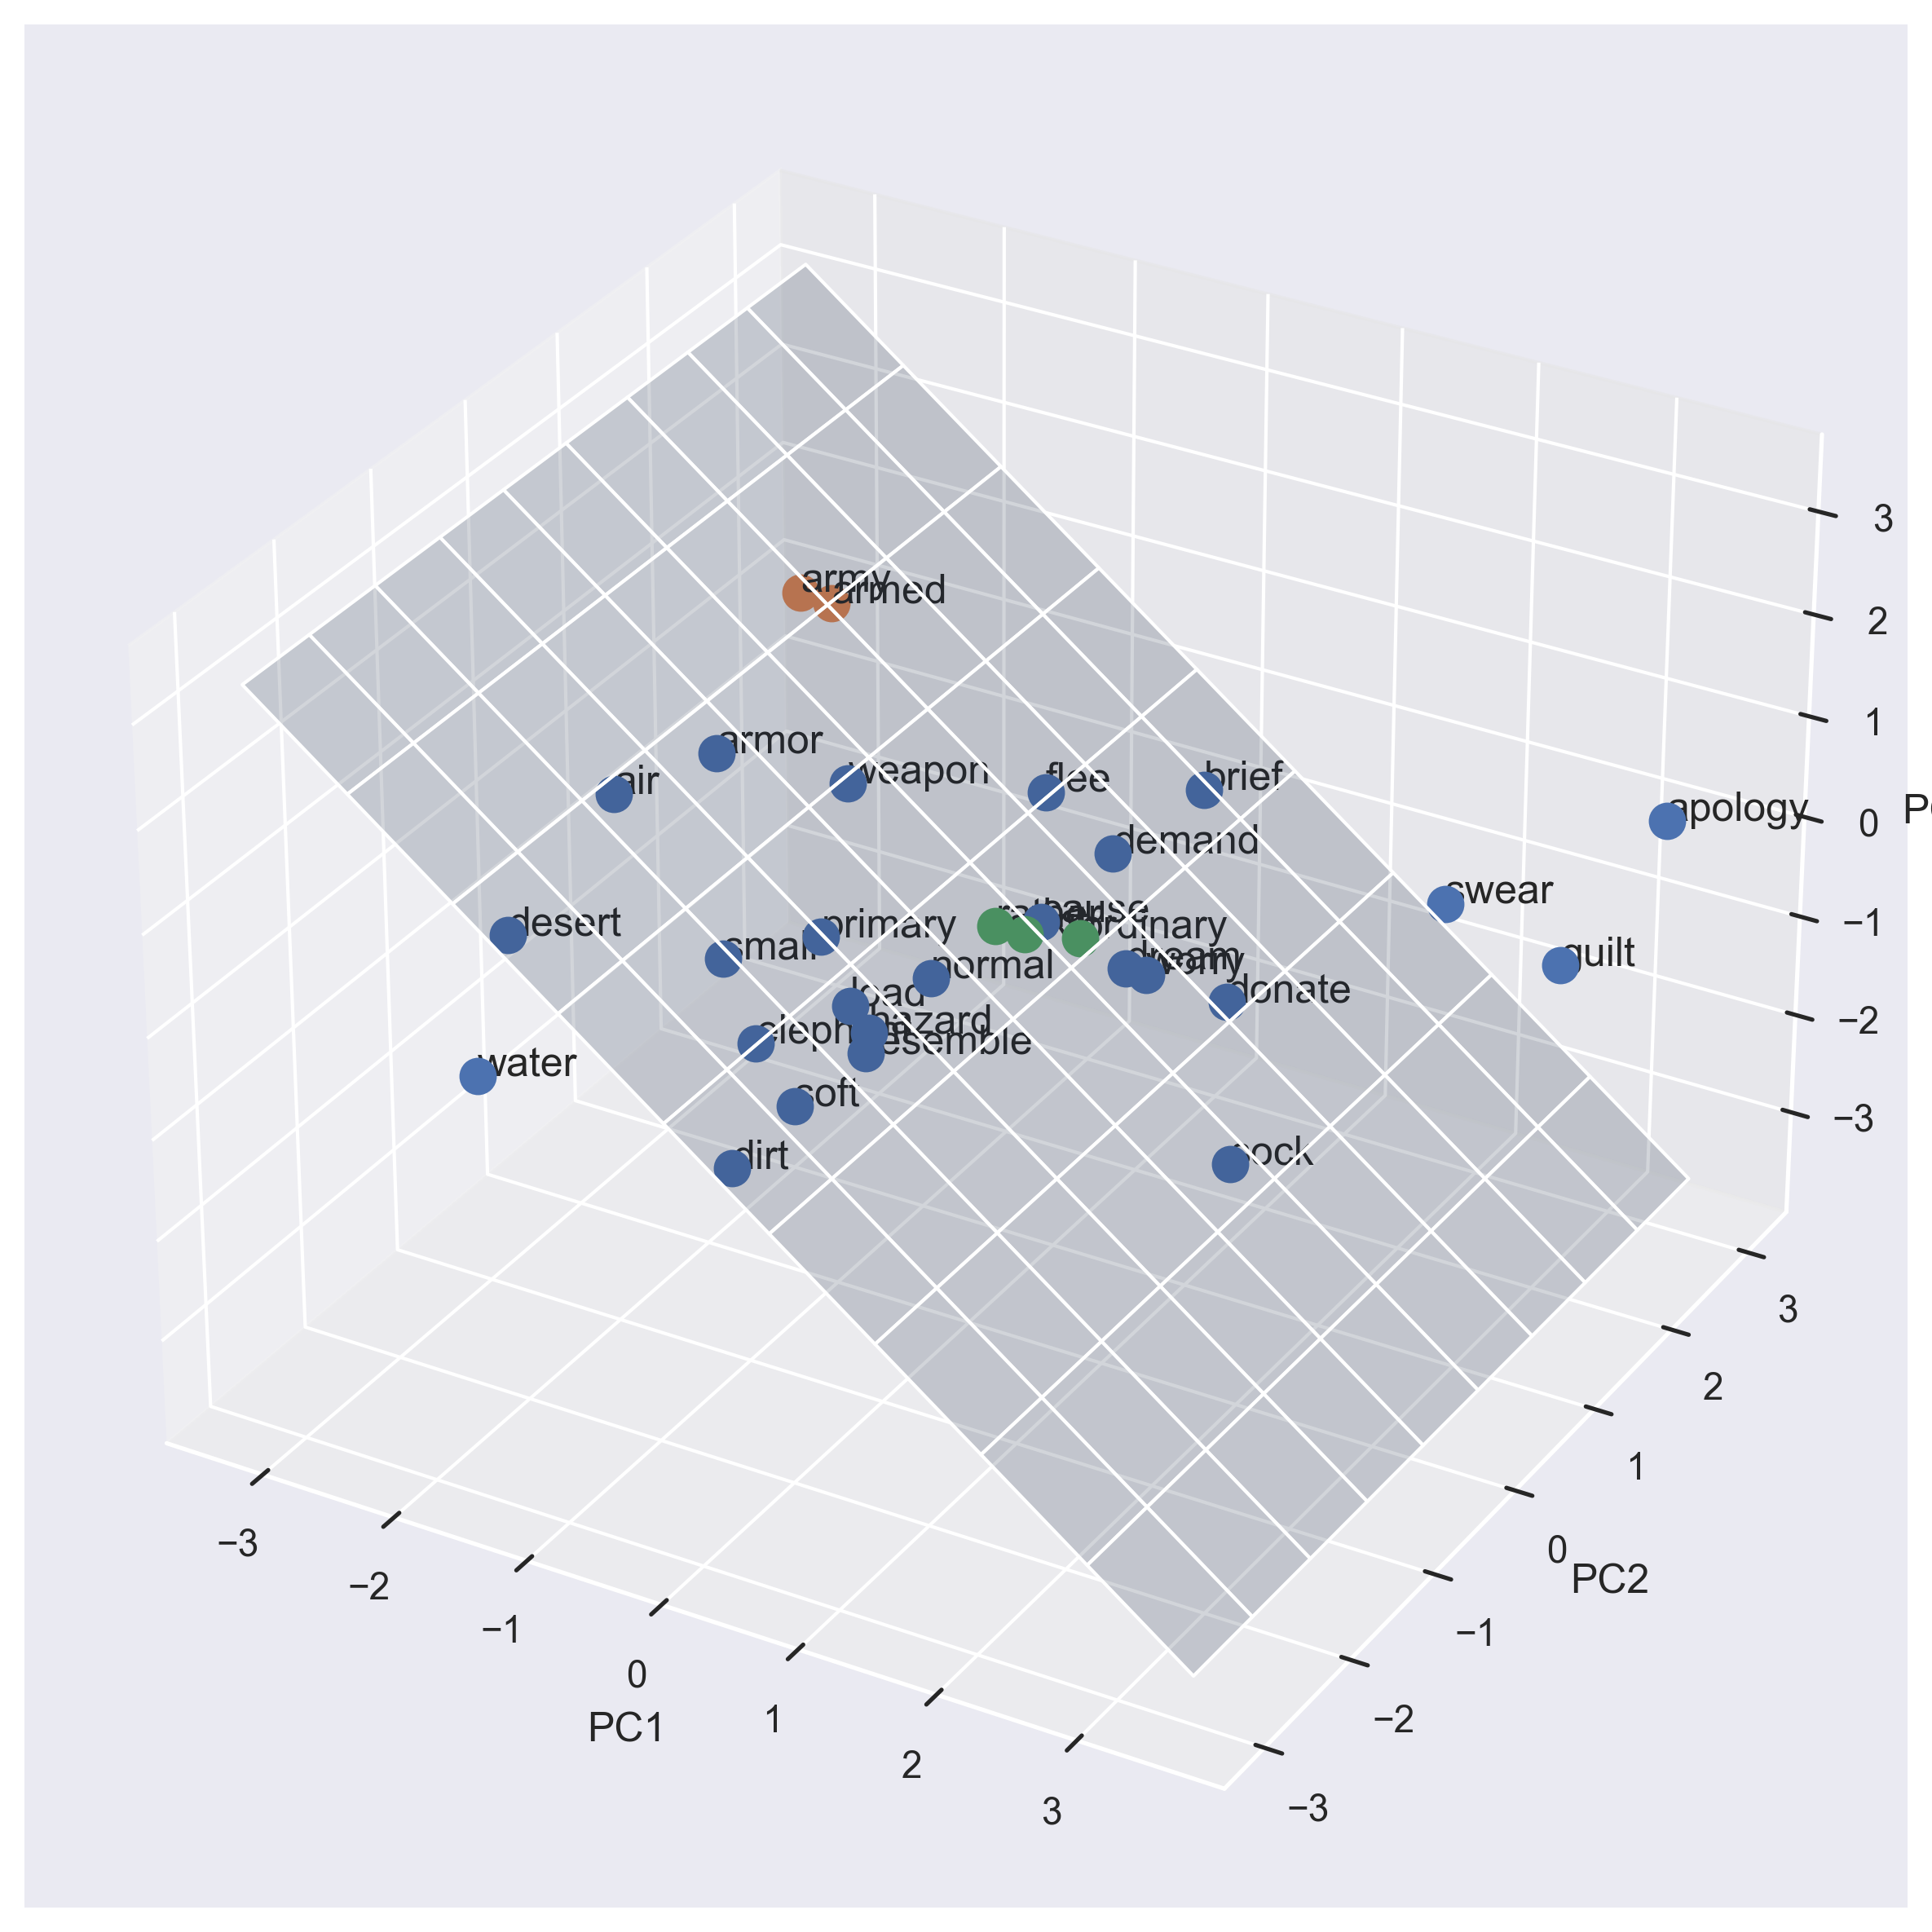

In [126]:
# Define the threshold distance
threshold = 0.5

# Create the word embeddings matrix
X = df[['x', 'y', 'z']].values



# Perform density-based clustering using DBSCAN
dbscan = DBSCAN(eps=threshold, min_samples=2, metric='euclidean')
clusters = dbscan.fit_predict(X)

# Get the indices of vectors that belong to the same cluster
cluster_indices = [np.where(clusters == i)[0] for i in np.unique(clusters) if i != -1]

# Get the centroid of each cluster
centroids = [np.mean(X[i], axis=0) for i in cluster_indices]

# Get the normal vector of the hyperplane
if len(centroids) > 2:
    vec1 = centroids[0] - centroids[1]
    vec2 = centroids[1] - centroids[2]
    normal = np.cross(vec1, vec2)
else:
    normal = [1, 0, 0]

# Check if the third element of the normal vector is zero, and if so, set it to a small non-zero value
if normal[2] == 0:
    normal[2] = 1e-6

# Create a meshgrid of points to represent the hyperplane
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 10)
y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 10)
xx, yy = np.meshgrid(x_range, y_range)
zz = (-normal[0] * xx - normal[1] * yy) / normal[2]

# Create the 3D scatter plot with the hyperplane
fig = plt.figure(figsize=(10, 10),dpi=300)
ax = fig.add_subplot(111, projection='3d')
for i in range(len(X)):
    color = sns.color_palette()[clusters[i] + 1]
    ax.scatter(X[i, 0], X[i, 1], X[i, 2], s=100,c=color)
    ax.text(X[i, 0], X[i, 1], X[i, 2], df['word'][i], fontsize=12)
ax.plot_surface(xx, yy, zz, alpha=0.2)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()
